In [1]:
!pip install -r requirements_for_gh200.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd
#import seaborn as sns

#from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.utils.checkpoint as checkpoint

import torchvision
from torchvision.transforms import v2

import warnings
import time
import functools
import copy
from tqdm import tqdm

from pyhessian import hessian

seed = 1001
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
import torchquantum as tq
from torchquantum.measurement import expval_joint_analytical

In [4]:
print(torch.__version__)
print(tq.__version__)

2.5.1
0.1.7


In [5]:
n_gpu = torch.cuda.device_count()
print(n_gpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print([torch.cuda.get_device_name('cuda:'+str(i)) for i in range(n_gpu)])

1
['NVIDIA GH200 480GB']


In [6]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True)
data_tr, label_tr = data.train_data, data.train_labels
data = torchvision.datasets.MNIST(root='./data', train=False, download=True)
data_te, label_te = data.test_data, data.test_labels
print(data_tr.shape, data_te.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


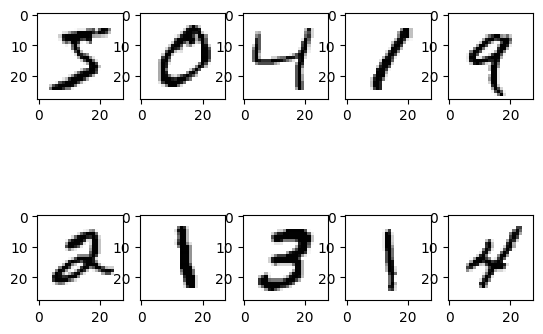

In [7]:
num = 10
for i in range(num):
    ax = plt.subplot(2,num//2,i+1)
    ax.imshow(data_tr[i].detach().numpy(), cmap='gray_r')

In [8]:
dataset_name = 'mnist'
n_class = len(np.unique(label_tr))

In [9]:
n_qubits = 8
n_depth_per_block = 100
n_qnn = 16

#assert n_qubits%2==0
n_half_qubits = n_qubits//2 # 3
n_latter_half_qubits = n_qubits-n_half_qubits

In [10]:
class ConstCoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = coeff
    def forward(self, x):
        ret = x * self.coeff
        return ret

In [11]:
def calc_exp_val(qdev, obs):
    assert len(obs)==n_qubits
    state2 = qdev.states.clone()
    for i in range(n_qubits):
        if obs[i]=='I':
            continue
        elif obs[i]=='X':
            mat = torch.tensor([[0,1],[1,0]])
        elif obs[i]=='Y':
            mat = torch.tensor([[0,-1j],[1j,0]])
        elif obs[i]=='Z':
            mat = torch.tensor([[1,0],[0,-1]])
        state2 = tq.functional.apply_unitary_bmm(state2, mat, [i])
    state1 = qdev.states.clone()
    exp_val = torch.einsum("bij...k,bij...k->b", state1.conj(), state2).real
    # to confirm the calculation of expectation values
    if False:
        bra = qdev.get_states_1d().clone().conj()
        ket = torch.reshape(state2, [bsz, 2**n_qubits])
        tmp_exp_val = torch.sum(bra*ket,dim=1).real # (bsz,dim) => (bsz)
        assert np.allclose(tmp_exp_val.detach().cpu().numpy(),exp_val.detach().cpu().numpy(),rtol=1e-5,atol=1e-5)
    return exp_val

In [12]:
# 14x14 => 7x14x2
# 2n_qubitsx28 => 14x7x8 = 14x28x2
class QNNsubModel(nn.Module):
    def __init__(self):
        # params is numpy array
        super().__init__()

    def forward(self, x, phi):
        bsz, nx_features = x.shape
        qdev = tq.QuantumDevice(
            n_wires=n_qubits, bsz = bsz, device=x.device, record_op=False
        )
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+2*k*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # x: 32, phi: 64
            for j in range(n_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # 32, 64
            for j in range(n_latter_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        j= 2
        for k in range(n_depth_per_block):
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k+1)*n_qubits])
            if (k==n_depth_per_block-1):
                break
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        obs_list = [ calc_exp_val(qdev, "I"*i+Pauli+"I"*(n_qubits-1-i)) for Pauli in ["X","Z"] for i in range(n_class//2)]
        ret = torch.stack(obs_list, dim=1)
        return ret

In [13]:
# 14x14 => 7x14x2
# 1:8, 7:14 -> 0:7, 6:13
# 1:8, 4:11, 7:14 -> 0:7, 3:10, 6:13
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.params_list = nn.ParameterList([torch.rand( (3*2*n_depth_per_block+2*n_qubits)*n_qubits )*math.pi for _ in range(n_qnn)])
        self.pos_bias = nn.Parameter( torch.zeros(14, 14, device=device) )
        self.qnn_list = [QNNsubModel() for _ in range(n_qnn)]
    def forward(self, x):
        n_data = len(x)
        in_x = x + self.pos_bias
        in_x = torch.stack([ in_x[:,i:i+n_qubits,j:j+n_qubits].reshape(n_data,n_qubits*n_qubits) for i in [0,2,4,6] for j in [0,2,4,6] ], axis=0) # (4,n_data,64)
        #ret_list = [checkpoint.checkpoint(self.qnn_list[i], in_x[i], self.params_list[i]) for i in range(n_qnn)]
        ret_list = [self.qnn_list[i](in_x[i], self.params_list[i]) for i in range(n_qnn)]
        ret = torch.stack(ret_list, axis=1) # (bsz, n_qnn, n_class)
        ret = torch.mean(ret, axis=1) # (bsz,n_class)
        return ret

In [14]:
def train(data, label, model, accumulation_steps):
    pred = model(data) # (bsz, n_class)
    loss = torch.nn.CrossEntropyLoss()(pred, label)
    loss = loss / accumulation_steps
    loss.backward()
    with torch.no_grad():
        pred_normalized = nn.functional.softmax(pred, dim=1)
        acc = (pred_normalized.argmax(axis=1) == label).sum().item() / len(label)
    print(f"train loss: {loss.item()*accumulation_steps:.5f} train acc: {acc:.3f}", end='\n')
    return loss.item(), acc

def valid(data, label, model):
    with torch.no_grad():
        pred = model(data)
        loss = torch.nn.CrossEntropyLoss()(pred, label)
        pred_normalized = nn.functional.softmax(pred, dim=1)
        acc = (pred_normalized.argmax(axis=1) == label).sum().item() / len(label)
    print(f"valid loss: {loss.item():.5f} valid acc: {acc:.3f}", end='\n')
    return loss.item(), acc

In [15]:
# normalization: /255*math.pi/n_half_qubits=/255*2*math.pi/n_qubits ??
data_tr = data_tr/255*2*math.pi/n_qubits
data_te = data_te/255*2*math.pi/n_qubits

data_tr = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_tr) # (28,28) -> (14,14)
data_te = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_te) # (28,28) -> (14,14)

#data_tr = data_tr.reshape(-1,data_tr.shape[1]*data_tr.shape[2]) #.detach().numpy()
#data_te = data_te.reshape(-1,data_te.shape[1]*data_te.shape[2]) #.detach().numpy()
print(data_tr.shape, data_te.shape)

torch.Size([60000, 14, 14]) torch.Size([10000, 14, 14])


In [16]:
max_epochs = 50
coeff=100
#data_tr, label_tr = data_tr.to(device), label_tr.to(device)
data_te, label_te = data_te.to(device), label_te.to(device)
model = torch.nn.Sequential(
    QNNModel(),
    ConstCoeffLayer(coeff)
)

# すべての点で求めて、手動で各local minimum の点を選ぶ.
dir_name = "tmp_"+str(n_qubits)+"qubits_"+str(n_qnn)+"qnn"
if n_depth_per_block>50:
    dir_name += str(n_depth_per_block)
prefix_name = dataset_name+"_"+str(n_qnn)+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)+"_"+str(n_qubits)+"qubits_ensembling_cos"

In [17]:
losses = pd.read_csv(dir_name+'/'+prefix_name+'_losses.csv')
min_index = losses['train_loss'].argmin()
min_epochs = losses['epochs'][min_index]
print(min_epochs, losses['train_loss'][min_index])

36 0.0090949814766645


In [18]:
# hessian_dataloader = (data_tr, label_tr)
dataloader = []
model = torch.nn.Sequential( QNNModel(), ConstCoeffLayer(coeff))
model.load_state_dict(torch.load(dir_name+'/'+prefix_name+'_epoch'+str(min_epochs)+'.pt', weights_only=True))
model = model.cuda()

tmp_skf = StratifiedKFold(n_splits=400, shuffle=True, random_state=0) # for minibatch training with shuffling the samples
for i_fold, (_, tmp_te) in enumerate(tmp_skf.split(data_tr, label_tr)):
    dataloader.append( (data_tr[tmp_te].to(device=device), label_tr[tmp_te].to(device=device)) )

model.eval()
#dataloader = [(data_tr[tmp_te].to(device=device), label_tr[tmp_te].to(device=device))]
#dataloader = [(data_tr.to(device=device), label_tr.to(device=device))]

Sequential(
  (0): QNNModel(
    (params_list): ParameterList(
        (0): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (4): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (5): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (6): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (7): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (8): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (9): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (10): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (11): Parameter containing: [torch.float32 of size 4928 (cuda:0)]
        (12): Parameter containing: [torch.float32 of size 

In [19]:
hessian_comp = hessian(model, torch.nn.CrossEntropyLoss(), dataloader=dataloader, cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)
print('Top Eigenvalues: ', top_eigenvalues)

Top Eigenvalues:  [4.172467231750488]
